In [1]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

In [2]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

Using TensorFlow backend.


In [3]:
bandwidth = 1#1e9                       # bandwidth
nsymbols = 16                    # Number of symbols
M = 16                                # size of the constellation
Nt = 2**10                           # Sample size
nLayers = 500                         # Number of Layers of the Generative network
nb = int(nsymbols * np.log2(M))       # Number of bits
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) ) # 40 #70 # int( (nb/bandwidth)+ (10*2/ nb) )

In [4]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
#params = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Transmitor
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

In [5]:
# Constellation
constellation, binaryStr, binaryArr = transmitor.build_constellations(parameters.M)
#source
source = transmitor.source(parameters.nb , parameters.p)
# symbol sequence
val_s = transmitor.bit_to_symb(source, parameters.M)

In [6]:
q0t = modulator.mod(parameters.t,val_s, parameters.B)
y_gen = nnetGen.nnet_gen(q0t)

C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


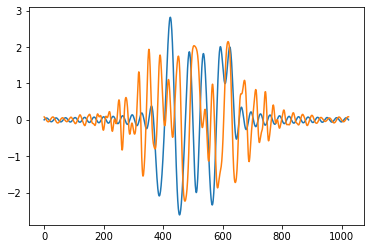

In [7]:
plt.plot(q0t)
plt.plot(y_gen)

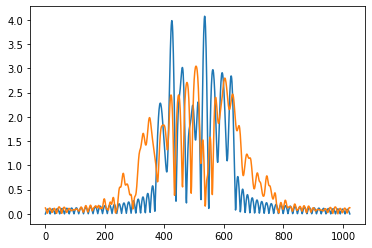

In [8]:
plt.plot(np.abs(q0t))
plt.plot(np.abs(y_gen))

# Data Gen

In [9]:
# Generating the dataset
def generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False):

    X = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)
    y = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)    
    bits_in = np.ndarray((nbrOfObservations, parameters.nb))
    bhat_out = np.ndarray((nbrOfObservations, parameters.nb))
    symb_in = np.ndarray((nbrOfObservations, parameters.n))
    symb_out = np.ndarray((nbrOfObservations, parameters.n))


    print("[INFO] Generating the dataset...")

    for i in tqdm(range(nbrOfObservations)):
        
        # Constellation
        constellation = transmitor.build_constellations(parameters.M)
        
        #source
        source = transmitor.source(parameters.nb , parameters.p) # USE IT FOR NEXT PART OF BITS
        
        # Bits to Symboles - symbol sequence
        bitsToSymbols = transmitor.bit_to_symb(source, parameters.M)

        # symbol sequence, we create a list of values of the complex symbols to use them in modulation
        s = transmitor.bit_to_symb(source, parameters.M)
        
        # channel - we take gaussian input
        if isGaussian:
            q0t = parameters.A*np.exp(-parameters.t**2) 

        else :
            q0t = modulator.mod(parameters.t,s, parameters.B)  
        
        # Neural Net Generator
        y_gen = nnetGen.nnet_gen(q0t)
        # equalized y_gen
        qzte, qzfe = equalizer.equalize(parameters.t, y_gen, parameters.z) # equalized output
        qzte = qzte.reshape(1,-1)
        # demodulation
        shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

        # detection
        stilde, indexes = detector.detector(shat, parameters.M)
        bhat = detector.symbols_to_bit(indexes, parameters.M)
        
        # SOURCE IS THE SEQUENCE OF BITS TO BE LEARNED
        
        # Modulated signal
        X[i] = np.squeeze(q0t)
        # Neural Net Generator
        y[i] = y_gen
        # original bit sequence (source)
        bits_in[i] = source
        # estimated bit sequence
        bhat_out[i] = bhat
        # original symbol sequence (source)

        symb_in[i] = np.squeeze(s)
        # estimated symbol sequence
        symb_out[i] = np.squeeze(shat)
        
    print("[INFO] The dataset is ready now !")

    return X, y, bits_in, bhat_out, symb_in, symb_out

In [18]:
nbrOfObservations = 10000 #(1h for 10k observations)

In [11]:
X, y, bits_in, bhat_out, symb_in, symb_out = generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

[INFO] Generating the dataset...


C:\Python36\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Python36\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.42it/s]

[INFO] The dataset is ready now !


In [12]:
print("X : ",X)
print("y : ",y)
print("bits_in : ",bits_in)
print("bhat_out : ",bhat_out)
print("symb_in : ",symb_in)
print("symb_out : ",symb_out)

X :  [[-4.87861799e-16+3.49822556e-18j -1.64439069e-02+1.15038332e-03j
  -3.23226858e-02+2.26622308e-03j ... -3.01569628e-02-2.15289967e-03j
  -1.53441135e-02-1.09301456e-03j -1.40357737e-16-7.69924288e-17j]
 [-6.33763932e-16-6.94818073e-16j -1.78259795e-02-2.51434488e-02j
  -3.50360621e-02-4.94246023e-02j ... -3.41983399e-02-4.43316423e-02j
  -1.74008276e-02-2.25572443e-02j -1.25359578e-16-5.52208531e-17j]
 [-8.78905738e-17-5.35690171e-16j  2.51321187e-03-3.23292766e-02j
   4.93179561e-03-6.35448552e-02j ...  8.73025230e-03-6.09452515e-02j
   4.44172360e-03-3.10090498e-02j  4.05669140e-16-6.02868826e-16j]
 ...
 [-3.50702414e-16-4.46288497e-16j -1.38552991e-02-5.42129865e-03j
  -2.72335971e-02-1.06461964e-02j ... -2.84526649e-02-2.13959268e-02j
  -1.44743356e-02-1.08793230e-02j -1.28433583e-16+2.02728427e-16j]
 [-7.01052835e-17+1.10916035e-15j -8.03847611e-03+1.77575415e-02j
  -1.57998659e-02+3.48943078e-02j ... -1.53173982e-02+4.29645065e-02j
  -7.79346309e-03+2.18554522e-02j -2.31655

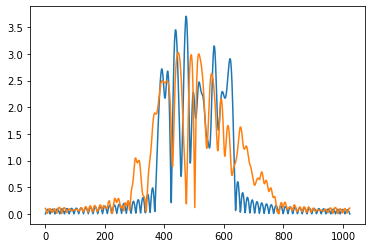

In [13]:
plt.plot(np.abs(X[0]))
plt.plot(np.abs(y[0]))

# Data preparation

In [15]:
t1 = time.time()
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)
#df.to_csv("../data/data_90K.csv.gz", index=False, compression="gzip")
t2 = time.time()
print("Toral time to prepare the dataframe is : ", t2-t1, " seconds.")

 22%|██████████████████                                                              | 45/200 [00:00<00:00, 436.90it/s]


 [INFO] {fromComplexToReal} runing...


 52%|████████████████████████████████████████▌                                     | 104/200 [00:00<00:00, 1033.22it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (200, 2048)

 [INFO] {fromComplexToReal} runing...


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 958.67it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (200, 2048)
{prepareDataFrame} df_.shape :  (200, 4096)
Toral time to prepare the dataframe is :  0.525623083114624  seconds.


In [16]:
n_samples, n_features = X.shape
n_hidden = 512

In [17]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (200, 2048)
y.shape :  (200, 2048)
X_train.shape :  (150, 2048, 1)
y_train.shape :  (150, 2048, 1)
X_test.shape :  (50, 2048, 1)
y_test.shape :  (50, 2048, 1)


In [18]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Model

In [20]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [21]:
rect_mlp.add(Dense(2048, input_shape=(n_features,)))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(512))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('selu'))

print ()
rect_mlp.summary(name="MLP")


+-----+
| MLP |
+-----+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 2098176    | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | (1024,)      |
| Dense              | 524800     | (512,)       |
| Activation (SELU)  | 0          | (512,)       |
| Dropout            | 0          | (512,)       |
| BatchNormalization | 1024       | (512,)       |
| Dense              | 525312     | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | 

In [22]:
num_epochs = 10
batch_size = 256

In [23]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  10


[INFO] Training loss on epoch  1  :  0.51806
[INFO] Validation loss on epoch  1  :  0.45594
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.45551
[INFO] Validation loss on epoch  2  :  0.48951
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.38984
[INFO] Validation loss on epoch  3  :  0.59075
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.33869
[INFO] Validation loss on epoch  4  :  0.83493
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.31109
[INFO] Validation loss on epoch  5  :  1.15077
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.29249
[INFO] Validation loss on epoch  6  :  1.49968
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28000
[INFO] Validation loss on epoch  7  :  1.84788
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.26379
[INFO] Validation loss on epoch  8  :  2.17695
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.25188
[INFO] Validation loss on epoch  9  :  2.43993
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.24087
[INFO] Validation loss on epoch  10  :  2.64036
-------------------------------------------------------------------------------


In [50]:
index_pred= 0
y_pred = evaluate_model(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect)

NameError: name 'evaluate_model' is not defined

## Performance evaluation

In [ ]:
s = bitToSymb(b, M)
q0t = mod(t, s, B)

In [51]:
y_pred

array([[-0.63005374, -1.59363084,  0.90690384, ...,  0.79101574,
        -1.34517683, -0.25255688]])

In [53]:
# propagation & equalization.
q0t = fromRealToComplex(y_pred)
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) # output in t,f
qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
# demodulation
shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

# detection
stilde, indexes = detector.detector(shat, M)
bhat = detector.symbols_to_bit(indexes, M)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.90it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
[channel] qzt : [[ 1.26500192+0.0019399j  -2.73153458+0.56513628j  1.06782327+0.17706405j
  ... -0.95139833+0.32534958j -2.29527718+0.84773806j
  -1.61576552-0.73295409j]]
[channel] qzf : [[ 231.90072498+221.27979258j -238.26652423 -91.82142005j
    98.03501858 +16.84368961j ... -239.27998915-226.70653915j
   300.02135842+281.54136407j -244.79443277-323.01794894j]]
[Equalizer] qzte : [[-0.63005376-1.59363079j  0.90690386-0.28902468j -0.2432705 -1.02888262j
  ... -1.58655644+1.13197743j -0.69098031+0.79101574j
  -1.34517682-0.2525569j ]]
[Equalizer] qzfe : [[ 231.90072498+221.27979258j -239.14044461 -89.52070989j
    98.61138699 +13.05255161j ... -258.02121583-205.12391446j
   310.65003401+269.76825528j -247.8963536 -320.64358332j]]


In [57]:
qzt.shape

(1, 1024)

In [29]:
shat

array([[-2.60733549-3.31454681j],
       [ 0.83178736+2.73640648j],
       [ 0.95153583-1.43414499j],
       [-0.07969793+3.19582603j],
       [ 1.51985879-3.22977955j],
       [-2.19806618+4.89734426j],
       [ 2.94428658+0.23852739j],
       [ 2.05109064+1.80774651j],
       [ 0.46441487+8.45062161j],
       [-1.95283607-1.12799967j],
       [-1.27438   -1.86820945j],
       [ 1.50666975-1.17863641j],
       [16.39241219-1.53011492j],
       [-1.34442668-1.45247614j],
       [ 0.34290359-1.97204797j],
       [-1.53898609+6.42212326j]])

In [34]:
b = transmitor.source(parameters.nb , parameters.p)
s = transmitor.bit_to_symb(b, 16)

In [35]:
shat.shape

(16, 1)

In [36]:
ser = detector.ser(s, shat)  # symbol error rate
ber = detector.ber(b, bhat)  # bit error rate

In [37]:
ser

75.44596722617987

In [38]:
ber

0.484375